In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.lines as mlines
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
def linear_regression(X,Y,lam=0):
    """
    Train linear regression model

        Parameters:
                X (np.array): A numpy array with the shape (N, d) where N is the number of data points and d is dimension
                Y (np.array): A numpy array with the shape (N,), where N is the number of data points
                lam (int): The regularization coefficient where default value is 0

        Returns:
                beta (np.array): A numpy array with the shape (d+1, 1) that represents the linear regression weight vector
    """
    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert Y.size == N

    Y_col = Y.reshape(-1,1)
    # your code here
    X_ = np.hstack([np.ones((N, 1)), X])
    X_t = X_.T
    # N * lam is only added accross the diagonal
    # of the of the "sum of squares of X matrix" (X.T @ X)
    I = np.eye(d+1) * N * lam
    beta = np.linalg.pinv(X_t @ X_ + I) @ (X_t @ Y_col)

    assert beta.shape == (d+1, 1)
    return beta

some_X = (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_beta = linear_regression(some_X, some_Y, lam=0)
assert np.array_equal(some_beta.round(3), np.array([[ 0.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.],
                                                    [ 1.]]))

some_beta_2 = linear_regression(some_X, some_Y, lam=1)
assert np.array_equal(some_beta_2.round(3), np.array([[0.032],
                                                      [0.887],
                                                      [1.08 ],
                                                      [1.035],
                                                      [0.86 ],
                                                      [1.021]]))

another_X = some_X.T
another_Y = np.sum(another_X, axis=1)
another_beta = linear_regression(another_X, another_Y, lam=0)
assert np.array_equal(another_beta.round(3), np.array([[-0.01 ],
                                                       [ 0.995],
                                                       [ 1.096],
                                                       [ 0.993],
                                                       [ 0.996],
                                                       [ 0.995],
                                                       [ 0.946],
                                                       [ 0.966]]))

In [3]:
def linear_predict(X,beta):
    """
    Predict with linear regression model

        Parameters:
                X (np.array): A numpy array with the shape (N, d) where N is the number of data points and d is dimension
                beta (np.array): A numpy array of the shape (d+1,1) where d is the data dimension

        Returns:
                y_hat (np.array): A numpy array with the shape (N, )
    """
    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert beta.shape == (d+1,1)

    # your code here
    X_ = np.hstack([np.ones((N, 1)), X])
    y_hat = X_ @ beta

    y_hat = y_hat.reshape(-1)
    assert y_hat.size == N
    return y_hat

some_X = (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_beta = 2.**(-np.arange(6).reshape(-1,1))
some_yhat = linear_predict(some_X, some_beta)
assert np.array_equal(some_yhat.round(3), np.array([ 3.062,  9.156,  6.188, 15.719,  3.062,  9.281,  7.062]))

In [4]:
def linear_residuals(X,beta,Y):
    """
    Calculate residual vector using linear_predict function

        Parameters:
                X (np.array): A numpy array with the shape (N, d) where N is the number of data points and d is dimension
                Y (np.array): A numpy array with the shape (N, ) where N is the number of data points
                beta (np.array): A numpy array of the shape (d+1,1) where d is the data dimension

        Returns:
                e (np.array): A numpy array with the shape (N, ) that represents the residual vector
    """

    assert X.ndim==2
    N = X.shape[0]
    d = X.shape[1]
    assert beta.shape == (d+1,1)
    assert Y.shape == (N,)

    # your code here
    e = Y - linear_predict(X, beta)

    e = e.reshape(-1)
    assert e.size == N
    return e

some_X = (np.arange(35, dtype='int64').reshape(7,5) ** 13) % 20
some_beta = 2.**(-np.arange(6).reshape(-1,1))
some_Y = np.sum(some_X, axis=1)
some_res = linear_residuals(some_X, some_beta, some_Y)
assert np.array_equal(some_res.round(3), np.array([16.938, 35.844, 33.812, 59.281, 16.938, 39.719, 16.938]))

In [5]:
df_1 = pd.read_csv('brunhild.txt', sep='\t')
df_1

,Hours,Sulfate
0,2,15.11
1,4,11.36
2,6,9.77
3,8,9.09
4,10,8.48
5,15,7.69
6,20,7.33
7,25,7.06
8,30,6.70
9,40,6.43


In [6]:
def newline(p1, p2, ax):
    # This code was borrowed from
    # https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

def draw_regression(X,Y,beta,ax):
    ax.scatter(X, Y, c='b', marker='o')
    line_obj = newline([0, np.sum(beta*np.array([[1],[0]]))], [2, np.sum(beta*np.array([[1],[2]]))], ax)
    line_obj.set_color('black')
    line_obj.set_linestyle('--')
    line_obj.set_linewidth(2)
    return ax

def set_ax_colors(ax):
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')

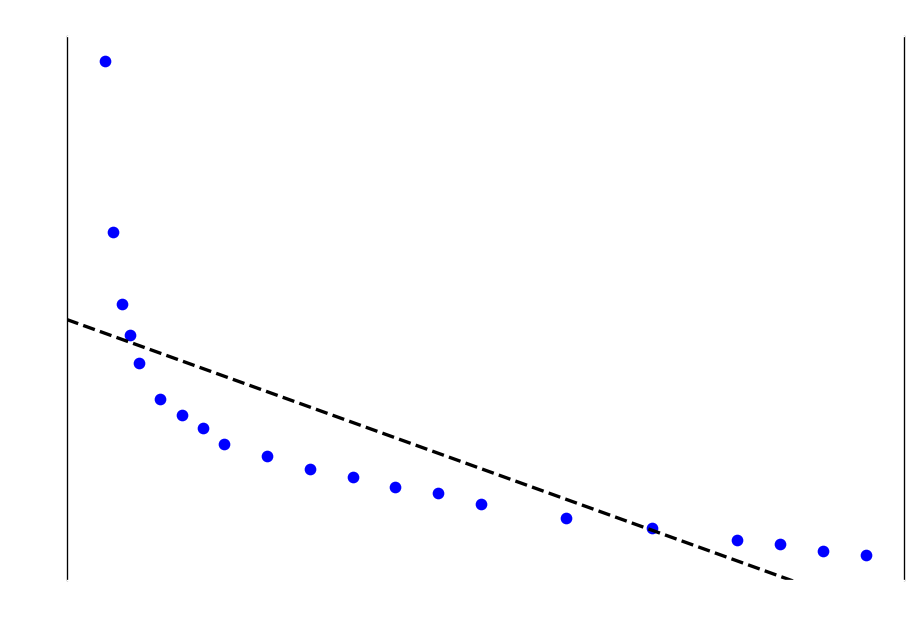

In [7]:
X_1 = df_1['Hours'].values.reshape(-1,1)
Y_1 = df_1['Sulfate'].values.reshape(-1)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_1 = linear_regression(X_1,Y_1,lam=0)
ax = draw_regression(X_1,Y_1,beta_1,ax)

residuals_1 = linear_residuals(X_1, beta_1, Y_1)
fitted_1 = linear_predict(X_1, beta_1)

r2_1 = r2_score(Y_1, fitted_1) #computes the R^2 score

ax.set_xlabel('Time')
ax.set_ylabel('Blood Sulfate')
_ = ax.set_title('Blood Sulfate Vs. Time Regression, R^2=%.2f' %r2_1)

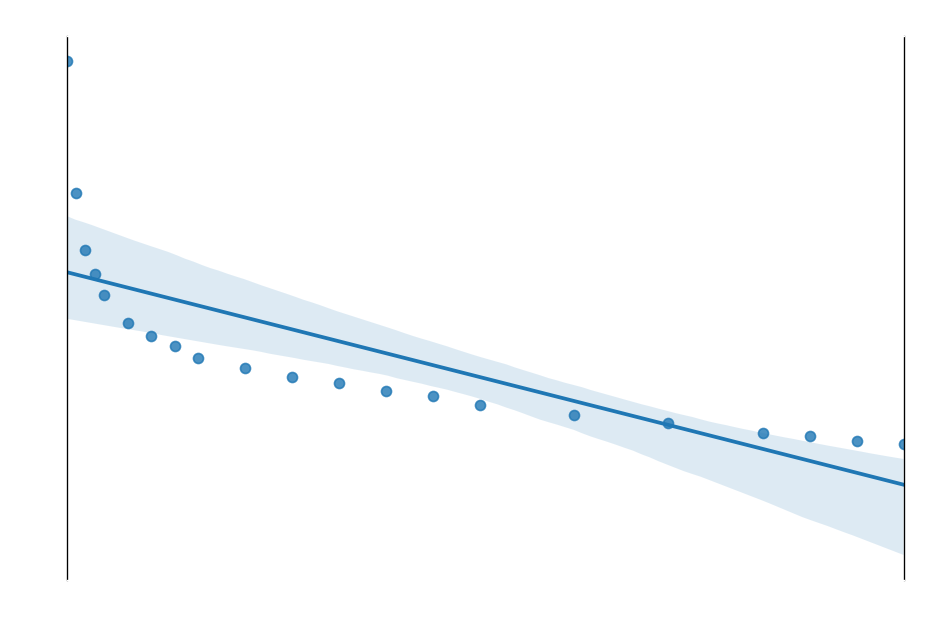

In [8]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)
sns.regplot(x='Hours', y='Sulfate', data=df_1, ax=ax)
_ = ax.set_title('Blood Sulfate Vs. Time Regression')

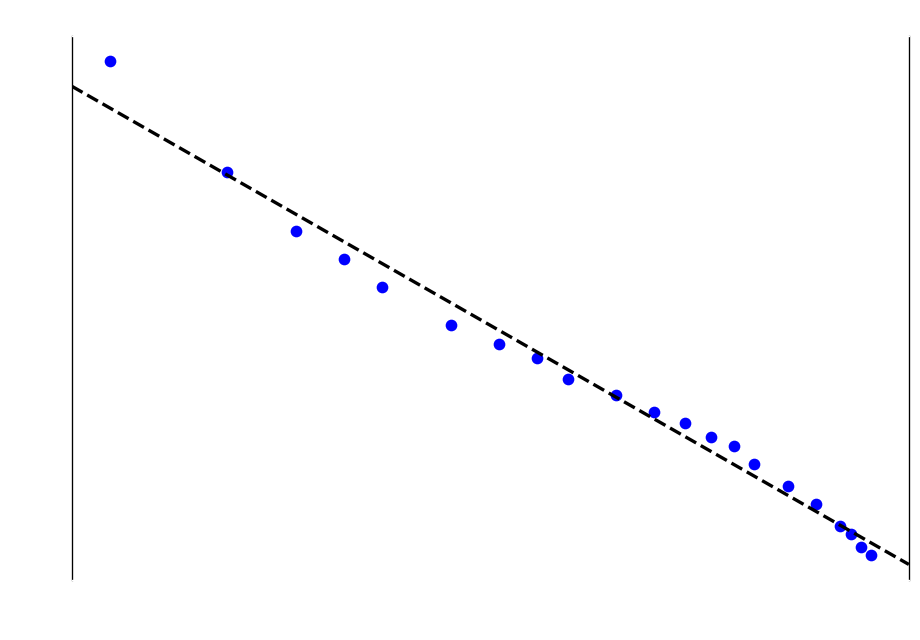

In [9]:
log_X_1 = np.log(df_1['Hours'].values.reshape(-1,1))
log_Y_1 = np.log(df_1['Sulfate'].values.reshape(-1))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_1_log = linear_regression(log_X_1,log_Y_1,lam=0)
residuals_1_log = linear_residuals(log_X_1, beta_1_log, log_Y_1)
fitted_1_log = linear_predict(log_X_1, beta_1_log)

r2_1_log = r2_score(log_Y_1, fitted_1_log) #computes the R^2 score

ax = draw_regression(log_X_1,log_Y_1,beta_1_log,ax)

ax.set_xlabel('Log Time')
ax.set_ylabel('Log Blood Sulfate')
_ = ax.set_title('Log Blood Sulfate Vs. Log Time Regression, R^2 = %.2f' %r2_1_log)

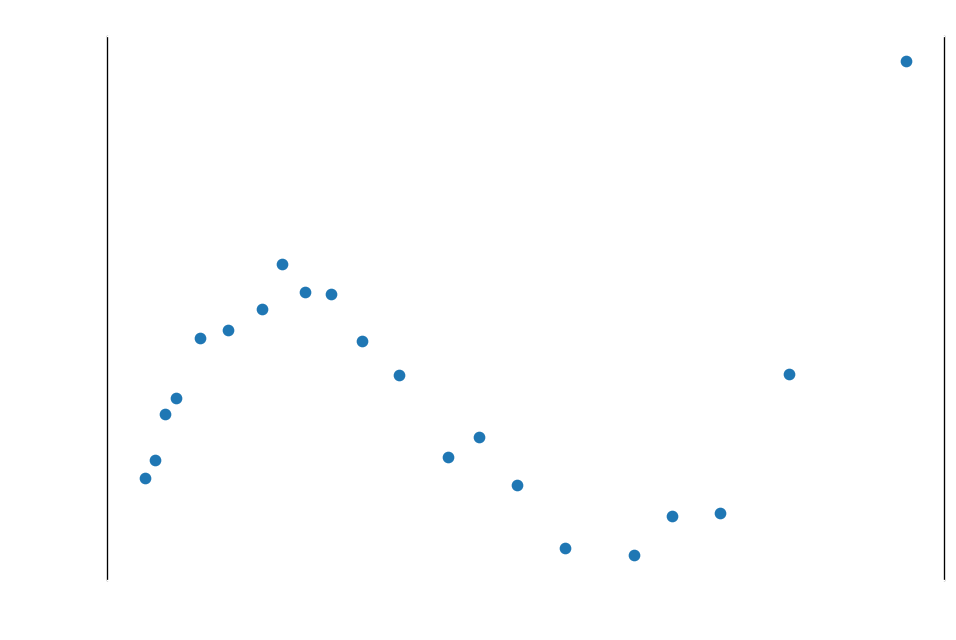

In [10]:
fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)
ax.scatter(fitted_1_log, residuals_1_log)

ax.set_xlabel('Fitted Log Blood Sulfate')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Values')

In [11]:
df_2 = pd.read_csv('physical.txt', sep='\t')
df_2

,Mass,Fore,Bicep,Chest,Neck,Shoulder,Waist,Height,Calf,Thigh,Head
0,77.0,28.5,33.5,100.0,38.5,114.0,85.0,178.0,37.5,53.0,58.0
1,85.5,29.5,36.5,107.0,39.0,119.0,90.5,187.0,40.0,52.0,59.0
2,63.0,25.0,31.0,94.0,36.5,102.0,80.5,175.0,33.0,49.0,57.0
3,80.5,28.5,34.0,104.0,39.0,114.0,91.5,183.0,38.0,50.0,60.0
4,79.5,28.5,36.5,107.0,39.0,114.0,92.0,174.0,40.0,53.0,59.0
5,94.0,30.5,38.0,112.0,39.0,121.0,101.0,180.0,39.5,57.5,59.0
6,66.0,26.5,29.0,93.0,35.0,105.0,76.0,177.5,38.5,50.0,58.5
7,69.0,27.0,31.0,95.0,37.0,108.0,84.0,182.5,36.0,49.0,60.0
8,65.0,26.5,29.0,93.0,35.0,112.0,74.0,178.5,34.0,47.0,55.5
9,58.0,26.5,31.0,96.0,35.0,103.0,76.0,168.5,35.0,46.0,58.0


mean square error: 2.61


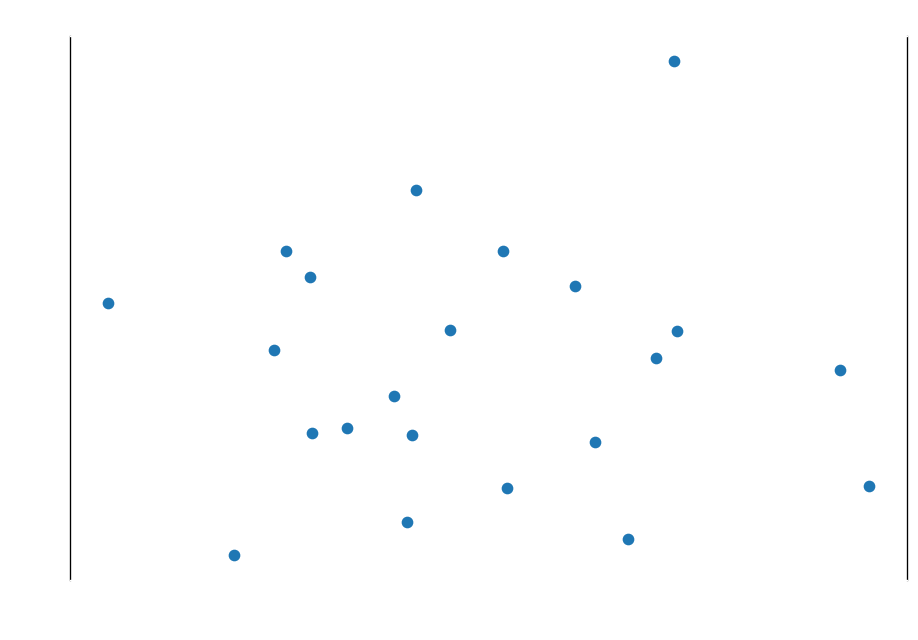

In [23]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2 = df_2['Mass'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_2 = linear_regression(X_2,Y_2,lam=0)
residuals_2 = linear_residuals(X_2, beta_2, Y_2)
fitted_2 = linear_predict(X_2, beta_2)

ax.scatter(fitted_2, residuals_2)
r2_2 = r2_score(Y_2, fitted_2)

ax.set_xlabel('Fitted Mass')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Mass, R^2 = %.2f' %r2_2)

print('mean square error: %.2f' %np.mean(residuals_2**2))

mean square error: 0.000987


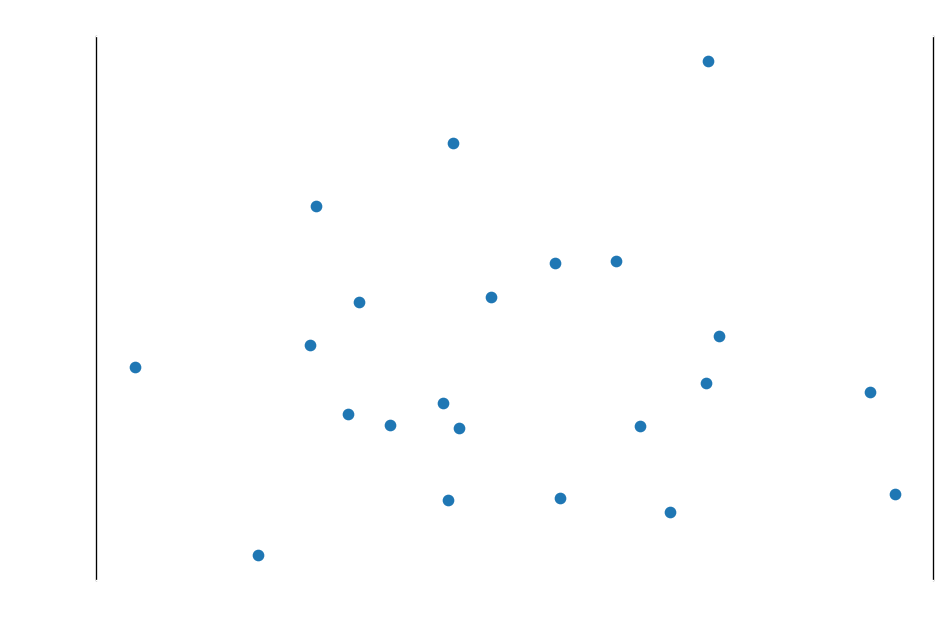

In [22]:
X_2 = df_2.loc[:, df_2.columns != 'Mass'].values
Y_2_cr = (df_2['Mass'].values**(1./3.))

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_2_cr = linear_regression(X_2,Y_2_cr,lam=0)
residuals_2_cr = linear_residuals(X_2, beta_2_cr, Y_2_cr)
fitted_2_cr = linear_predict(X_2, beta_2_cr)

ax.scatter(fitted_2_cr, residuals_2_cr)
r2_2_cr = r2_score(Y_2_cr, fitted_2_cr)

ax.set_xlabel('Fitted Cubic Root Mass')
ax.set_ylabel('Cubic Root Residuals')
_ = ax.set_title('Cubic Root Residuals Vs. Fitted Cubic Root Mass, R^2 = %.2f' %r2_2_cr)

print('mean square error: %.6f' %np.mean(residuals_2_cr**2))

In [14]:
df_3 = pd.read_csv('abalone.data', sep=',', header=None)
df_3.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
              'Viscera weight', 'Shell weight', 'Rings']
df_3

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


mean square error = 4.91


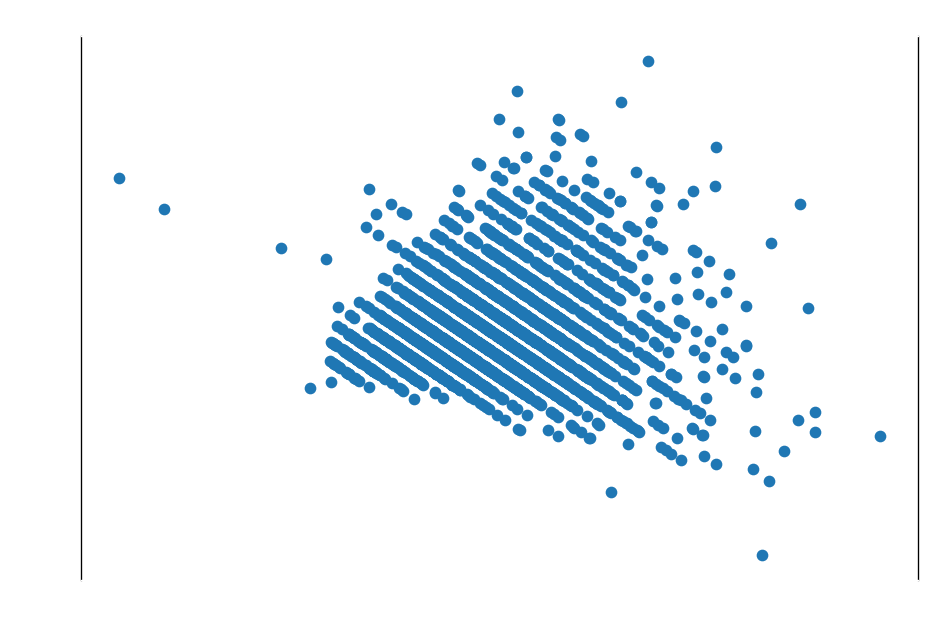

In [15]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_3 = linear_regression(X_3,Y_3,lam=0)
residuals_3 = linear_residuals(X_3, beta_3, Y_3)
fitted_3 = linear_predict(X_3, beta_3)

ax.scatter(fitted_3, residuals_3)
r2_3 = r2_score(Y_3, fitted_3)

ax.set_xlabel('Fitted Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Ignoring Gender), R^2 = %.2f' %r2_3)

print('mean square error = %.2f' %np.mean(residuals_3**2))

mean square error = 4.85


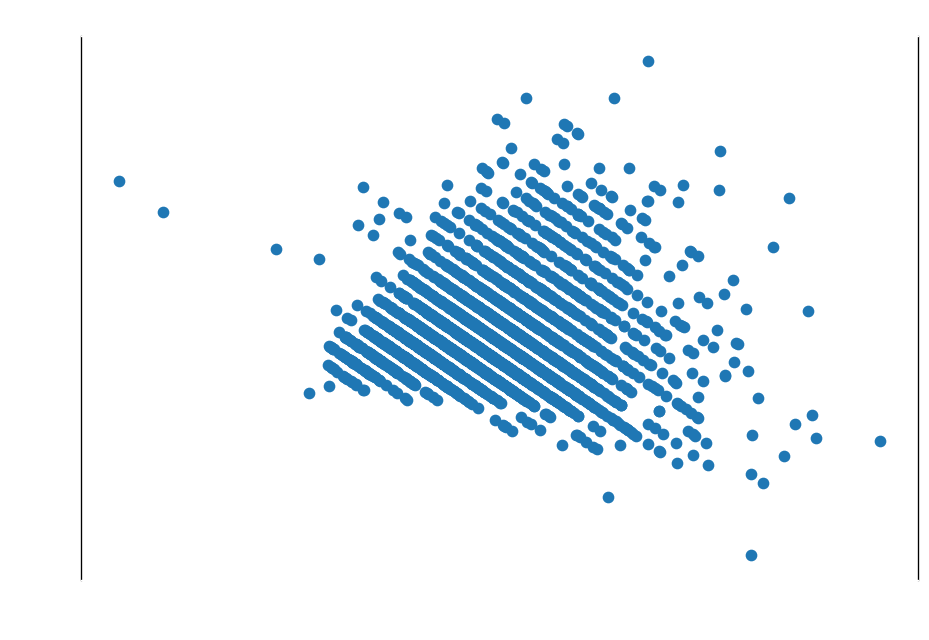

In [16]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_3_gender = linear_regression(X_3_gender,Y_3,lam=0)
residuals_3_gender = linear_residuals(X_3_gender, beta_3_gender, Y_3)
fitted_3_gender = linear_predict(X_3_gender, beta_3_gender)

ax.scatter(fitted_3_gender, residuals_3_gender)
r2_3_gender = r2_score(Y_3, fitted_3_gender)

ax.set_xlabel('Fitted Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Age (Including Gender), R^2 = %.2f' %r2_3_gender)

print('mean square error = %.2f' %np.mean(residuals_3_gender**2))

0.48905695644235236
mean square error (in the original coordinates) = 5.31


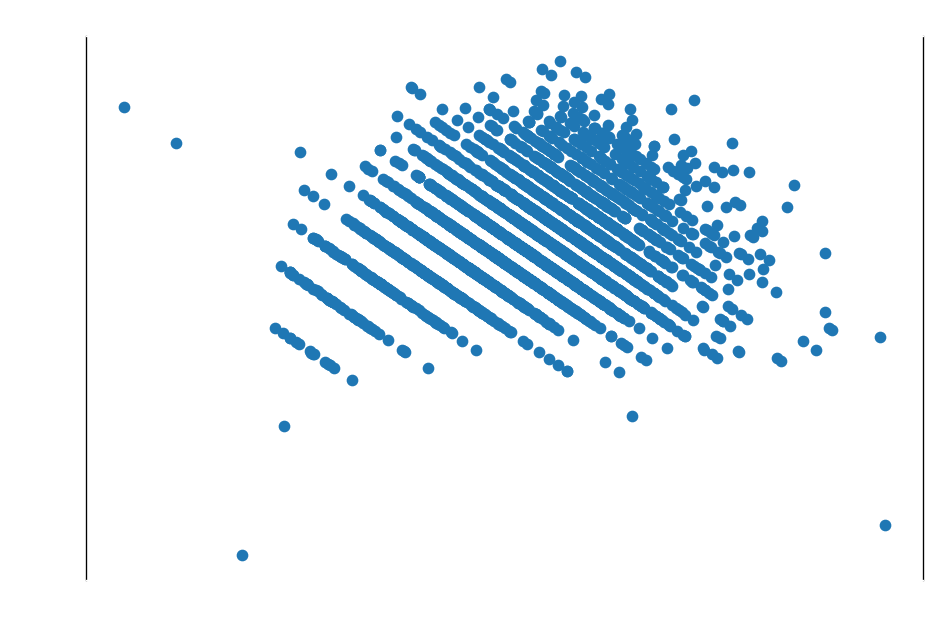

In [17]:
X_3 = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_3_log = linear_regression(X_3,Y_3_log,lam=np.exp(-13))
residuals_3_log = linear_residuals(X_3, beta_3_log, Y_3_log)
fitted_3_log = linear_predict(X_3, beta_3_log)

ax.scatter(fitted_3_log, residuals_3_log)
r2_3_log = r2_score(Y_3_log, fitted_3_log)

ax.set_xlabel('Fitted Log Age (Ignoring Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Ignoring Gender), R^2 = %.2f' %r2_3_log)

fitted_3_log_orig = np.exp(fitted_3_log) #predicted values back to the original coordinates
residuals_3_log_orig = Y_3 - fitted_3_log_orig #residuals in the original coordinates
print(r2_score(Y_3, fitted_3_log_orig))
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_log_orig**2))

mean square error (in the original coordinates) = 5.24


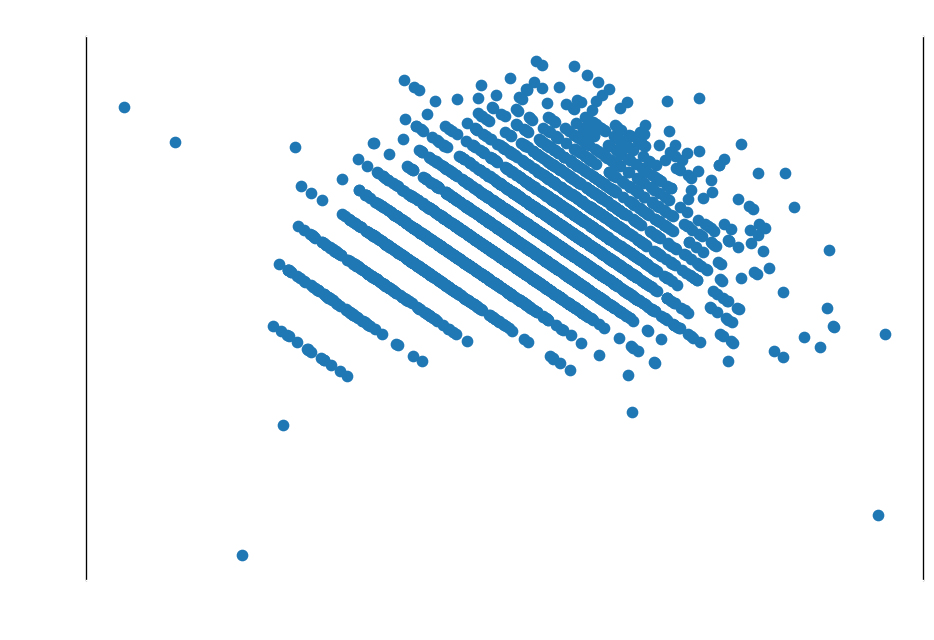

In [18]:
X_3_gender = df_3.loc[:, (df_3.columns != 'Rings') & (df_3.columns != 'Sex')].values
X_3_gender = np.concatenate([X_3_gender, np.array([{'F':1, 'M':0, 'I':-1}.get(x) for x in df_3.Sex]).reshape(-1,1)], axis=1)
Y_3 = df_3['Rings'].values
Y_3_log = np.log(df_3['Rings'].values)

fig, ax = plt.subplots(figsize=(9,6.), dpi=120)
set_ax_colors(ax)

beta_3_gender_log = linear_regression(X_3_gender,Y_3_log,lam=0)
residuals_3_gender_log = linear_residuals(X_3_gender, beta_3_gender_log, Y_3_log)
fitted_3_gender_log = linear_predict(X_3_gender, beta_3_gender_log)

ax.scatter(fitted_3_gender_log, residuals_3_gender_log)
r2_3_gen_log = r2_score(Y_3_log, fitted_3_gender_log)

ax.set_xlabel('Fitted Log Age (Including Gender)')
ax.set_ylabel('Residuals')
_ = ax.set_title('Residuals Vs. Fitted Log Age (Including Gender), R^2 = %.2f' %r2_3_gen_log)

fitted_3_gender_log_orig = np.exp(fitted_3_gender_log) # predicted values back to the original coordinates
residuals_3_gender_log = Y_3 - fitted_3_gender_log_orig
print('mean square error (in the original coordinates) = %.2f' %np.mean(residuals_3_gender_log**2))